## Work
1. 試比較有 BN 在 Batch_size = 2, 16, 32, 128, 256 下的差異
2. 請嘗試將 BN 放在 Activation 之前，並比較訓練結果
3. 請於 BN 放在 Input Layer 後，並比較結果

In [1]:
import os
from tensorflow.python import keras
import itertools
# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\python\framework\dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
C:\Users\Hero3C\Anaconda3\envs\keras\lib\site-packages\tensorflow\pyth

In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [5]:
from tensorflow.python.keras.layers import BatchNormalization
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(input_layer)
            x = BatchNormalization()(x)
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            x = BatchNormalization()(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
       

In [6]:
##BN 放在 Activation 之前
from tensorflow.python.keras.layers import BatchNormalization
def build_mlp1(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = BatchNormalization()(input_layer)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
        else:
            x = BatchNormalization()(x)
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
##BN 放在 Input Layer 後
from tensorflow.python.keras.layers import BatchNormalization
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    """Code Here
    建立你的神經網路
    """
    input_layer = keras.layers.Input(input_shape)
    x = BatchNormalization()(input_layer)
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
        else:
            x = keras.layers.Dense(units=n_units, 
                                   activation="relu", 
                                   name="hidden_layer"+str(i+1))(x)
            
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model
       

In [8]:
"""Code Here
設定超參數
"""
LEARNING_RATE = 1e-2
EPOCHS = 50
BATCH_SIZE = [128, 256, 1024]
MOMENTUM = 0.95

In [9]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_S in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.3f" % (BATCH_S))
    model = build_mlp(input_shape=x_train.shape[1:])
    model.summary()
    
    #optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=0.0) 
    #optimizer = keras.optimizers.RMSprop(lr=lr, epsilon=None, decay=0.0)
    #optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_S, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "BATCH_SIZE-%s" % str(BATCH_S)
    results[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BATCH_SIZE = 128.000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization (BatchNo (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
batch_normalization_2 (B

50000/50000 [==============================] - 7s 141us/sample - loss: 0.4720 - accuracy: 0.8313 - val_loss: 2.2671 - val_accuracy: 0.4752
Epoch 44/50
50000/50000 [==============================] - 7s 139us/sample - loss: 0.4537 - accuracy: 0.8347 - val_loss: 2.2648 - val_accuracy: 0.4859
Epoch 45/50
50000/50000 [==============================] - 7s 143us/sample - loss: 0.4414 - accuracy: 0.8399 - val_loss: 2.3116 - val_accuracy: 0.4806
Epoch 46/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.4390 - accuracy: 0.8407 - val_loss: 2.4252 - val_accuracy: 0.4773
Epoch 47/50
50000/50000 [==============================] - 7s 145us/sample - loss: 0.4272 - accuracy: 0.8455 - val_loss: 2.3006 - val_accuracy: 0.4836
Epoch 48/50
50000/50000 [==============================] - 7s 138us/sample - loss: 0.4150 - accuracy: 0.8509 - val_loss: 2.5222 - val_accuracy: 0.4666
Epoch 49/50
50000/50000 [==============================] - 7s 141us/sample - loss: 0.4062 - accuracy: 0.85

50000/50000 [==============================] - 5s 105us/sample - loss: 0.3657 - accuracy: 0.8671 - val_loss: 2.4483 - val_accuracy: 0.4762
Epoch 38/50
50000/50000 [==============================] - 5s 95us/sample - loss: 0.3423 - accuracy: 0.8767 - val_loss: 2.6744 - val_accuracy: 0.4691
Epoch 39/50
50000/50000 [==============================] - 5s 101us/sample - loss: 0.3459 - accuracy: 0.8762 - val_loss: 2.6611 - val_accuracy: 0.4519
Epoch 40/50
50000/50000 [==============================] - 5s 100us/sample - loss: 0.3312 - accuracy: 0.8812 - val_loss: 2.6787 - val_accuracy: 0.4554
Epoch 41/50
50000/50000 [==============================] - 5s 98us/sample - loss: 0.3268 - accuracy: 0.8820 - val_loss: 2.6566 - val_accuracy: 0.4679
Epoch 42/50
50000/50000 [==============================] - 5s 100us/sample - loss: 0.3203 - accuracy: 0.8851 - val_loss: 2.7319 - val_accuracy: 0.4695
Epoch 43/50
50000/50000 [==============================] - 5s 100us/sample - loss: 0.2960 - accuracy: 0.8939

50000/50000 [==============================] - 3s 61us/sample - loss: 0.1964 - accuracy: 0.9424 - val_loss: 2.5687 - val_accuracy: 0.4754
Epoch 32/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.1764 - accuracy: 0.9497 - val_loss: 2.6440 - val_accuracy: 0.4699
Epoch 33/50
50000/50000 [==============================] - 3s 60us/sample - loss: 0.1554 - accuracy: 0.9562 - val_loss: 2.5645 - val_accuracy: 0.4758
Epoch 34/50
50000/50000 [==============================] - 3s 59us/sample - loss: 0.1417 - accuracy: 0.9605 - val_loss: 2.7107 - val_accuracy: 0.4676
Epoch 35/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.1304 - accuracy: 0.9653 - val_loss: 2.7515 - val_accuracy: 0.4671
Epoch 36/50
50000/50000 [==============================] - 3s 60us/sample - loss: 0.1231 - accuracy: 0.9662 - val_loss: 2.7169 - val_accuracy: 0.4760
Epoch 37/50
50000/50000 [==============================] - 3s 62us/sample - loss: 0.1093 - accuracy: 0.9716 - va

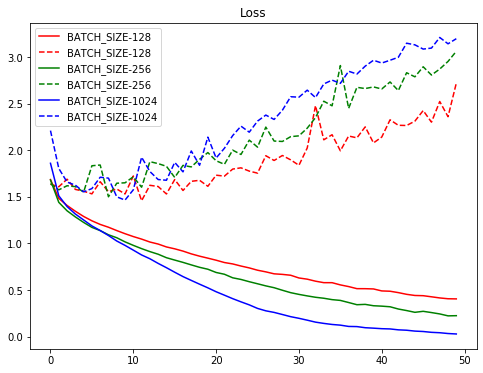

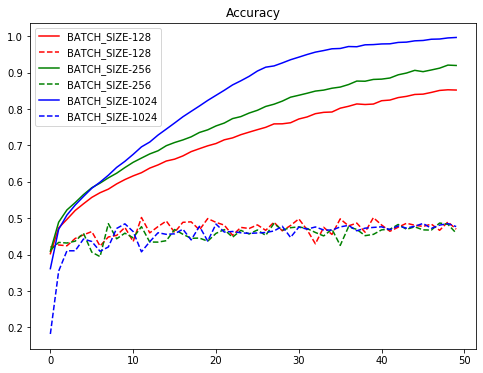

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [11]:
##BN 放在 Activation 之前
results1 = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_S in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.3f" % (BATCH_S))
    model = build_mlp1(input_shape=x_train.shape[1:])
    model.summary()
    
    #optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=0.0) 
    #optimizer = keras.optimizers.RMSprop(lr=lr, epsilon=None, decay=0.0)
    #optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_S, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "BATCH_SIZE-%s" % str(BATCH_S)
    results1[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BATCH_SIZE = 128.000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
hidden_layer3 (Dense)   

50000/50000 [==============================] - 8s 155us/sample - loss: 0.1121 - accuracy: 0.9600 - val_loss: 3.0089 - val_accuracy: 0.5467
Epoch 46/50
50000/50000 [==============================] - 7s 136us/sample - loss: 0.0938 - accuracy: 0.9669 - val_loss: 3.1135 - val_accuracy: 0.5318
Epoch 47/50
50000/50000 [==============================] - 7s 139us/sample - loss: 0.0983 - accuracy: 0.9651 - val_loss: 3.1020 - val_accuracy: 0.5383
Epoch 48/50
50000/50000 [==============================] - 7s 137us/sample - loss: 0.0899 - accuracy: 0.9685 - val_loss: 3.1525 - val_accuracy: 0.5401
Epoch 49/50
50000/50000 [==============================] - 7s 142us/sample - loss: 0.0865 - accuracy: 0.9692 - val_loss: 3.1858 - val_accuracy: 0.5396
Epoch 50/50
50000/50000 [==============================] - 7s 139us/sample - loss: 0.0848 - accuracy: 0.9709 - val_loss: 3.1931 - val_accuracy: 0.5400
Experiment with BATCH_SIZE = 256.000
Model: "model"
______________________________________________________

50000/50000 [==============================] - 5s 94us/sample - loss: 0.0817 - accuracy: 0.9723 - val_loss: 3.0584 - val_accuracy: 0.5364
Epoch 40/50
50000/50000 [==============================] - 4s 86us/sample - loss: 0.0713 - accuracy: 0.9750 - val_loss: 3.0245 - val_accuracy: 0.5421
Epoch 41/50
50000/50000 [==============================] - 4s 85us/sample - loss: 0.0639 - accuracy: 0.9777 - val_loss: 3.0666 - val_accuracy: 0.5415
Epoch 42/50
50000/50000 [==============================] - 5s 94us/sample - loss: 0.0638 - accuracy: 0.9779 - val_loss: 3.0953 - val_accuracy: 0.5362
Epoch 43/50
50000/50000 [==============================] - 5s 96us/sample - loss: 0.0581 - accuracy: 0.9806 - val_loss: 3.1487 - val_accuracy: 0.5346
Epoch 44/50
50000/50000 [==============================] - 5s 99us/sample - loss: 0.0666 - accuracy: 0.9774 - val_loss: 3.1889 - val_accuracy: 0.5302
Epoch 45/50
50000/50000 [==============================] - 5s 92us/sample - loss: 0.0712 - accuracy: 0.9759 - va

Epoch 34/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.0067 - accuracy: 0.9999 - val_loss: 2.8463 - val_accuracy: 0.5247
Epoch 35/50
50000/50000 [==============================] - 3s 62us/sample - loss: 0.0055 - accuracy: 1.0000 - val_loss: 2.8690 - val_accuracy: 0.5244
Epoch 36/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.0045 - accuracy: 1.0000 - val_loss: 2.8825 - val_accuracy: 0.5253
Epoch 37/50
50000/50000 [==============================] - 3s 59us/sample - loss: 0.0040 - accuracy: 1.0000 - val_loss: 2.9074 - val_accuracy: 0.5234
Epoch 38/50
50000/50000 [==============================] - 3s 62us/sample - loss: 0.0035 - accuracy: 1.0000 - val_loss: 2.9282 - val_accuracy: 0.5243
Epoch 39/50
50000/50000 [==============================] - 3s 64us/sample - loss: 0.0033 - accuracy: 1.0000 - val_loss: 2.9486 - val_accuracy: 0.5245
Epoch 40/50
50000/50000 [==============================] - 3s 63us/sample - loss: 0.0031 - accuracy:

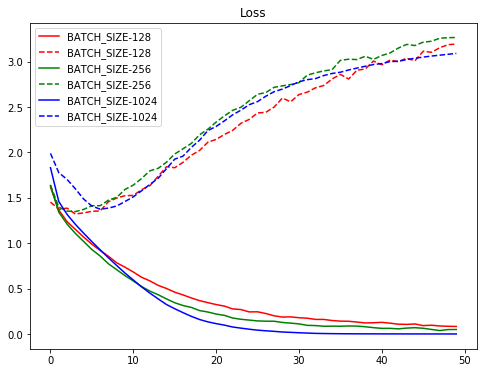

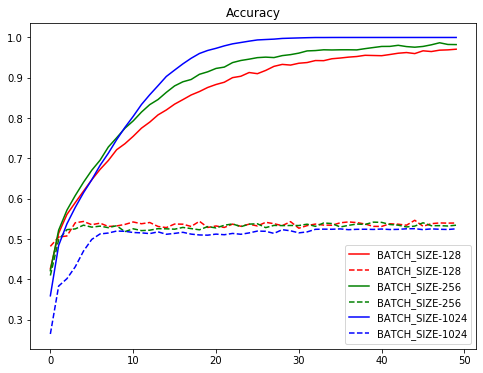

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-loss'])),results1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-loss'])),results1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-acc'])),results1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-acc'])),results1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

In [13]:
##BN 放在 Input Layer 後
results2 = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for BATCH_S in BATCH_SIZE:
    keras.backend.clear_session() # 把舊的 Graph 清掉
    print("Experiment with BATCH_SIZE = %.3f" % (BATCH_S))
    model = build_mlp2(input_shape=x_train.shape[1:])
    model.summary()
    
    #optimizer = keras.optimizers.Adam(lr=LEARNING_RATE, epsilon=None, decay=0.0) 
    #optimizer = keras.optimizers.RMSprop(lr=lr, epsilon=None, decay=0.0)
    #optimizer = keras.optimizers.Adagrad(lr=lr, epsilon=None, decay=0.0)
    optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
    
    model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

    model.fit(x_train, y_train, 
              epochs=EPOCHS, 
              batch_size=BATCH_S, 
              validation_data=(x_test, y_test), 
              shuffle=True)
    
    # Collect results
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]
    train_acc = model.history.history["accuracy"]
    valid_acc = model.history.history["val_accuracy"]
    
    exp_name_tag = "BATCH_SIZE-%s" % str(BATCH_S)
    results2[exp_name_tag] = {'train-loss': train_loss,
                             'valid-loss': valid_loss,
                             'train-acc': train_acc,
                             'valid-acc': valid_acc}


Experiment with BATCH_SIZE = 128.000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,751,178
Trainable params: 1,745,034
Non-trainable params: 6,144
__________

50000/50000 [==============================] - 6s 117us/sample - loss: 0.2226 - accuracy: 0.9273 - val_loss: 3.1450 - val_accuracy: 0.5294
Epoch 48/50
50000/50000 [==============================] - 6s 123us/sample - loss: 0.2166 - accuracy: 0.9310 - val_loss: 3.1981 - val_accuracy: 0.5272
Epoch 49/50
50000/50000 [==============================] - 6s 124us/sample - loss: 0.2059 - accuracy: 0.9333 - val_loss: 3.2976 - val_accuracy: 0.5285
Epoch 50/50
50000/50000 [==============================] - 6s 116us/sample - loss: 0.2089 - accuracy: 0.9322 - val_loss: 3.2909 - val_accuracy: 0.5254
Experiment with BATCH_SIZE = 256.000
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 3072)]            0         
_________________________________________________________________
batch_normalization (BatchNo (None, 3072)              12288     
__________________________

50000/50000 [==============================] - 4s 81us/sample - loss: 0.1079 - accuracy: 0.9637 - val_loss: 3.4795 - val_accuracy: 0.5287
Epoch 44/50
50000/50000 [==============================] - 4s 75us/sample - loss: 0.1170 - accuracy: 0.9604 - val_loss: 3.4560 - val_accuracy: 0.5268
Epoch 45/50
50000/50000 [==============================] - 4s 76us/sample - loss: 0.1248 - accuracy: 0.9580 - val_loss: 3.4610 - val_accuracy: 0.5232
Epoch 46/50
50000/50000 [==============================] - 4s 83us/sample - loss: 0.1164 - accuracy: 0.9610 - val_loss: 3.4108 - val_accuracy: 0.5300
Epoch 47/50
50000/50000 [==============================] - 4s 85us/sample - loss: 0.1140 - accuracy: 0.9621 - val_loss: 3.5256 - val_accuracy: 0.5292
Epoch 48/50
50000/50000 [==============================] - 4s 81us/sample - loss: 0.1131 - accuracy: 0.9616 - val_loss: 3.5020 - val_accuracy: 0.5256
Epoch 49/50
50000/50000 [==============================] - 4s 83us/sample - loss: 0.1089 - accuracy: 0.9639 - va

50000/50000 [==============================] - 3s 60us/sample - loss: 0.0108 - accuracy: 0.9992 - val_loss: 3.2308 - val_accuracy: 0.5240
Epoch 40/50
50000/50000 [==============================] - 3s 57us/sample - loss: 0.0078 - accuracy: 0.9998 - val_loss: 3.2679 - val_accuracy: 0.5277
Epoch 41/50
50000/50000 [==============================] - 3s 60us/sample - loss: 0.0058 - accuracy: 0.9998 - val_loss: 3.2722 - val_accuracy: 0.5285
Epoch 42/50
50000/50000 [==============================] - 3s 60us/sample - loss: 0.0051 - accuracy: 0.9998 - val_loss: 3.3159 - val_accuracy: 0.5307
Epoch 43/50
50000/50000 [==============================] - 3s 61us/sample - loss: 0.0047 - accuracy: 0.9997 - val_loss: 3.3205 - val_accuracy: 0.5304
Epoch 44/50
50000/50000 [==============================] - 3s 59us/sample - loss: 0.0041 - accuracy: 1.0000 - val_loss: 3.3424 - val_accuracy: 0.5294
Epoch 45/50
50000/50000 [==============================] - 3s 57us/sample - loss: 0.0032 - accuracy: 1.0000 - va

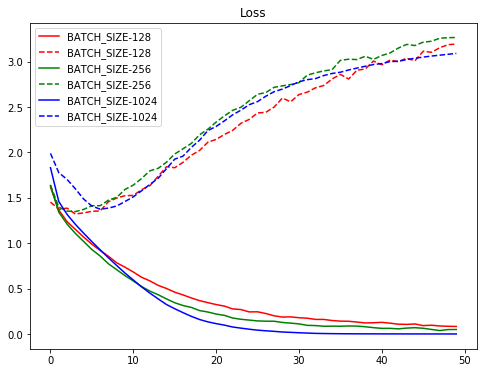

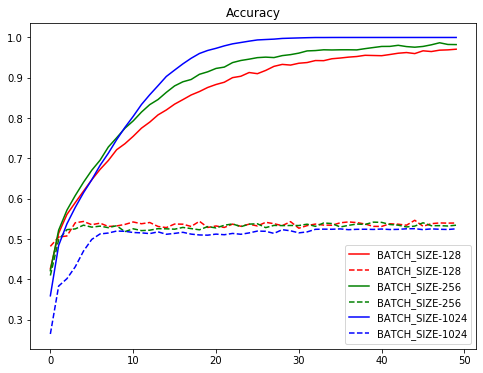

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

"""
將實驗結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k"]

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-loss'])),results1[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-loss'])),results1[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(8,6))
for i, cond in enumerate(results1.keys()):
    plt.plot(range(len(results1[cond]['train-acc'])),results1[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results1[cond]['valid-acc'])),results1[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()